In [1]:
import pandas as pd 
import shap
import numpy as np 
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

In [2]:
def checkCorrectParameters(alpha = 0,type = 'mult',sistema_contribucion = 'feature'):
    #if sistema_contribucion == '' not in
    if type not in ['mult','suma','suma_pon','mult_plus']:
        assert False, 'Invalid type. Must be mult, suma or suma_pon'
    if type == 'suma_pon' and alpha == 0:
        assert False, 'Invalid alpha, must be > 0'
    if sistema_contribucion not in ['feature_tree','feature_lin','shap']:
        assert False, 'Invalid sistema_contribucion. Must be featImportance or shap'

In [101]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def combination(s,s_prima,alpha = 0,type = 'mult', scaled = False):
    """
    Combines two lists element-wise based on the specified method.
    Parameters:
    s (list): The first list of numerical values.
    s_prima (list): The second list of numerical values.
    alpha (float, optional): The weight for the 'suma_pon' method. Default is 0.
    type (str, optional): The type of combination to perform. 
                            Options are 'mult' for multiplication, 'suma' for addition, 
                            and 'suma_pon' for weighted sum. Default is 'mult'.
    scaled (bool, optional): If True, the input lists will be normalized before combination. Default is False.
    Returns:
    list: A list containing the element-wise combination of s and s_prima based on the specified method.
    """
    
    # if scaled:
        # scaler = MinMaxScaler()
        # s = scaler.fit_transform(np.array(s).reshape(-1, 1)).flatten()
        # s_prima = scaler.fit_transform(np.array(s_prima).reshape(-1, 1)).flatten()

    if type == 'mult':
        return [s[i]*s_prima[i] for i in range(len(s))]
    elif type == 'mult_plus':
        return [s[i]*(s_prima[i]+1) for i in range(len(s))]
    elif type == 'suma':
        return [s[i]+s_prima[i] for i in range(len(s))]
    elif type == 'suma_pon':
        return [s[i]*alpha+s_prima[i]*(1-alpha) for i in range(len(s))]

In [63]:
def calcular_contribucion(df, model, sistema_contribucion = 'shap',num_valores_contribucion = 300):
    """
    Returns:
    dict: A dictionary containing the contribution of each feature to the model's predictions.
    """
    if sistema_contribucion == 'feature_tree':
        feat_imp = model.feature_importances_
        return {df.columns[i]: feat_imp[i] for i in range(len(df.columns))}
    elif sistema_contribucion == 'feature_lin':
        feat_imp = abs(model.coef_)
        return {df.columns[i]: feat_imp[i] for i in range(len(df.columns))}
    elif sistema_contribucion == 'shap':
        explainer = shap.KernelExplainer(model.predict, df[:num_valores_contribucion])   # mayor num_valores_contribucion indica mas precision pero mas coste computacional
        shap_values = explainer(df[:num_valores_contribucion])
        abs_feature_importance = np.abs(shap_values.values).mean(axis=0)
        dict_abs_feature_importance = dict(zip(df.columns, abs_feature_importance))
        return dict_abs_feature_importance

    pass

In [5]:
def calculate_correlation_matrix(S,E):  
    """
    Calculate the correlation matrix between two DataFrames.
    This function computes the absolute correlation values between the columns
    of two DataFrames, S and E, and returns the result as a new DataFrame.
    Parameters:
    S (pd.DataFrame): A DataFrame where each column represents a variable.
    E (pd.DataFrame): Another DataFrame where each column represents a variable.
    Returns:
    pd.DataFrame: A DataFrame containing the absolute correlation values between
                    the columns of S and E. The index of the resulting DataFrame
                    corresponds to the columns of E, and the columns correspond to
                    the columns of S.
    """


    correlation_matrix = pd.DataFrame(index=E.columns, columns=S.columns)
        # Compute correlations
    for no_inter in E.columns:
        for inter in S.columns:
            correlation_matrix.loc[no_inter,inter] = abs(S[inter].corr(E[no_inter]))
    correlation_matrix = correlation_matrix.astype('float16')
    return correlation_matrix

In [45]:
def draw_s_star_barplot(axis,S_columns,s,s_star):

    star_minus_s = [star-normal for star,normal in zip(s_star,s)]

    # Plot the base values
    axis.bar(S_columns, s, color='blue', label='Valor Base')

    # Plot the increments on top of the base values
    axis.bar(S_columns, star_minus_s, bottom=s, color='orange', label='Contribucion')

    #axis.bar(S_columns,s_star,color='orange')

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

In [167]:
def algoritmo_obtencion_valores(df, vars_no_inter,model, sistema_combinacion = 'mult', scaled = False, alpha = 0, sistema_contribucion = 'feature',num_valores_contribucion = 300, verbose = 0):
    checkCorrectParameters(alpha,sistema_combinacion,sistema_contribucion)
    # PASO 1
    contribuciones = calcular_contribucion(df,model,sistema_contribucion,num_valores_contribucion)
    if verbose > 1:
        plt.figure(figsize=(6, 6))

        plt.bar(df.columns,contribuciones.values())
        for var in vars_no_inter:
            plt.bar(var,contribuciones[var], color = 'red')
        plt.title('Contribuciones')
        plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.tight_layout()
        plt.xticks(rotation=90)

        plt.show()
    # PASO 2
    S = df.drop(columns=vars_no_inter)
    E = df[vars_no_inter]
    matrix_correlation = calculate_correlation_matrix(S,E)
    if verbose > 1:
        plt.figure(figsize=(6, 6))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Correlation Matrix Heatmap")
        plt.show()
    # PASO 3
    s_prima = {}
    if scaled:
        scaler = MinMaxScaler()
        val_contribuciones = [value for key, value in contribuciones.items() if key in df.columns]
        scaled_val_contribuciones = scaler.fit_transform(np.array(val_contribuciones).reshape(-1, 1)).flatten()
        scaled_contribuciones = {df.columns[i]: scaled_val_contribuciones[i] for i in range(len(df.columns))}

    for s in S:
        s_prima[s] = 0
        for e in E:
            if scaled:
                s_prima[s] += matrix_correlation.loc[e,s]*scaled_contribuciones[e]
            
            else:

                # e_pos = df.columns.get_loc(e)
                s_prima[s] += matrix_correlation.loc[e,s]*contribuciones[e]
                # if e == 'total sulfur dioxide':
                    # print(f'{matrix_correlation.loc[e,s]=}')
                    # print(f'{contribuciones[e]=}')
                    # print(f'{s_prima[s]=}')
                    # print('.---')
            
    # PASO 4
    s = [value for key, value in contribuciones.items() if key in S.columns]
    s_prima = list(s_prima.values())
    if scaled:
        scaler = MinMaxScaler()
        # scaler = StandardScaler()
        s = [value for key, value in scaled_contribuciones.items() if key in S.columns]
        #s = scaler.fit_transform(np.array(s).reshape(-1, 1)).flatten()
        #s_prima = scaler.fit_transform(np.array(s_prima).reshape(-1, 1)).flatten()
        
    s_star = combination(s,s_prima,alpha,sistema_combinacion,scaled)
    if verbose > 0:
        fig,ax = plt.subplots(1,3,sharey=True,figsize=(14, 4))
        # ax[0].bar(contribuciones.keys(),contribuciones.values(), color = 'blue')
        ax[0].bar(S.columns,s, color = 'blue')
        ax[1].bar(S.columns,s_prima, color = 'red')
        draw_s_star_barplot(ax[2],S.columns,s,s_star)
        #ax[2].bar(S.columns,s_star,color='orange')

        ax[0].set_title('S')
        ax[2].set_title('S_star')
        ax[1].set_title('S_prima')

        plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
        for axis in ax:
            axis.tick_params(axis='x', rotation=90)
            axis.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.show()
    return s_star


In [104]:
algoritmo_obtencion_valores(X, vars_no_inter=['BloodPressure'],model=model, sistema_combinacion = 'mult_plus', scaled = True, alpha = 0, 
                            sistema_contribucion = 'feature_tree',num_valores_contribucion = 300, verbose = 2)

IndexError: index 8 is out of bounds for axis 0 with size 8

In [53]:
import numpy as np
algoritmo_obtencion_valores(X, vars_no_inter=['total sulfur dioxide'],model=model_lr, sistema_combinacion = 'mult_plus', scaled = True, alpha = 0, 
                            sistema_contribucion = 'feature_lin',num_valores_contribucion = 300, verbose = 2)

IndexError: index 11 is out of bounds for axis 0 with size 11

In [54]:
algoritmo_obtencion_valores(X, vars_no_inter=['total sulfur dioxide'],model=model_lr, sistema_combinacion = 'mult', scaled = True, alpha = 0, 
                            sistema_contribucion = 'feature_lin',num_valores_contribucion = 300, verbose = 1)

IndexError: index 11 is out of bounds for axis 0 with size 11

## Ejemplios

Ejemplo de clasificación para el dataset diabetes

In [161]:
# Load the dataset # https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset 
df = pd.read_csv('diabetes.csv')

# Split into X,y and train and test
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
60,2,84,0,0,0,0.0,0.304,21
618,9,112,82,24,0,28.2,1.282,50
346,1,139,46,19,83,28.7,0.654,22
294,0,161,50,0,0,21.9,0.254,65
231,6,134,80,37,370,46.2,0.238,46


In [162]:
# Entrenamos a nuestro modelo de caja negra

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.81        99
           1       0.67      0.62      0.64        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.73       154
weighted avg       0.75      0.75      0.75       154



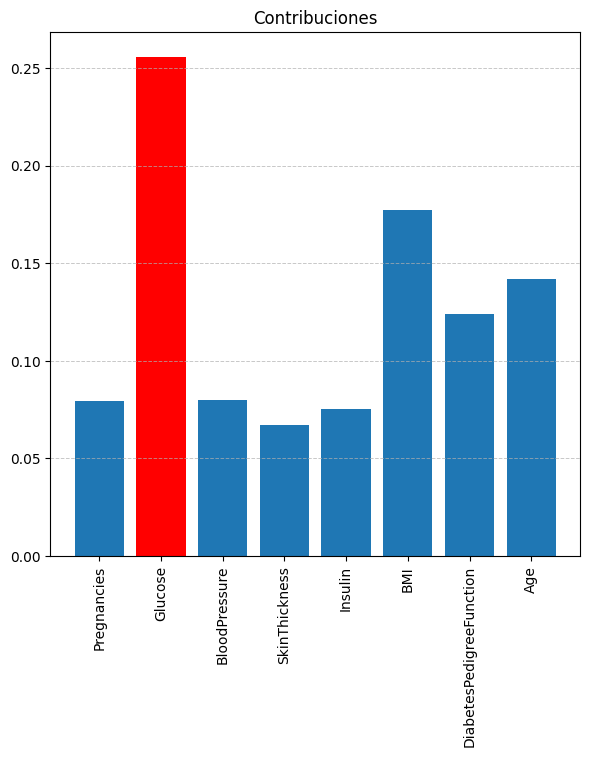

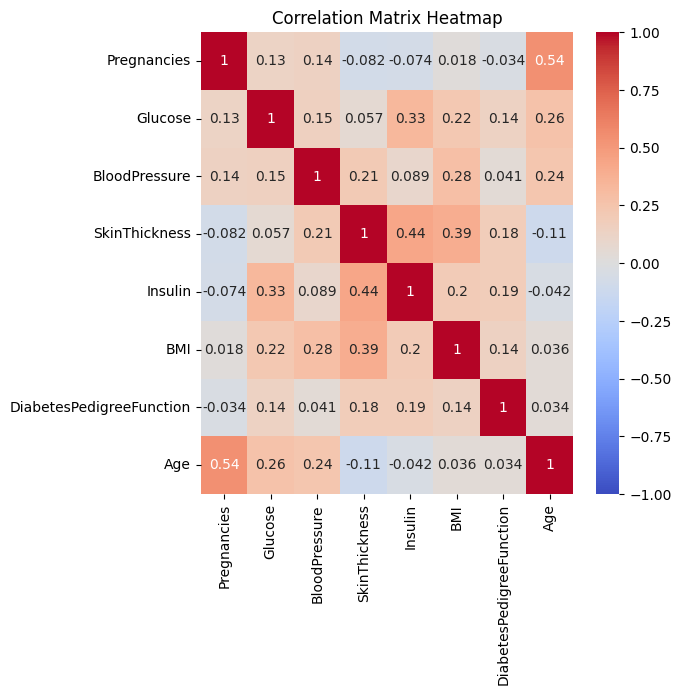

{'Pregnancies': 0.06463657252280697, 'Glucose': 0.9999999999999999, 'BloodPressure': 0.06851907122629652, 'SkinThickness': 0.0, 'Insulin': 0.04396405994955538, 'BMI': 0.5840070860681135, 'DiabetesPedigreeFunction': 0.3022991005752037, 'Age': 0.3960418376433307}
[0.12951660156249997, 0.15258789062499997, 0.05734252929687499, 0.33129882812499994, 0.22106933593749997, 0.13732910156249997, 0.26342773437499994]


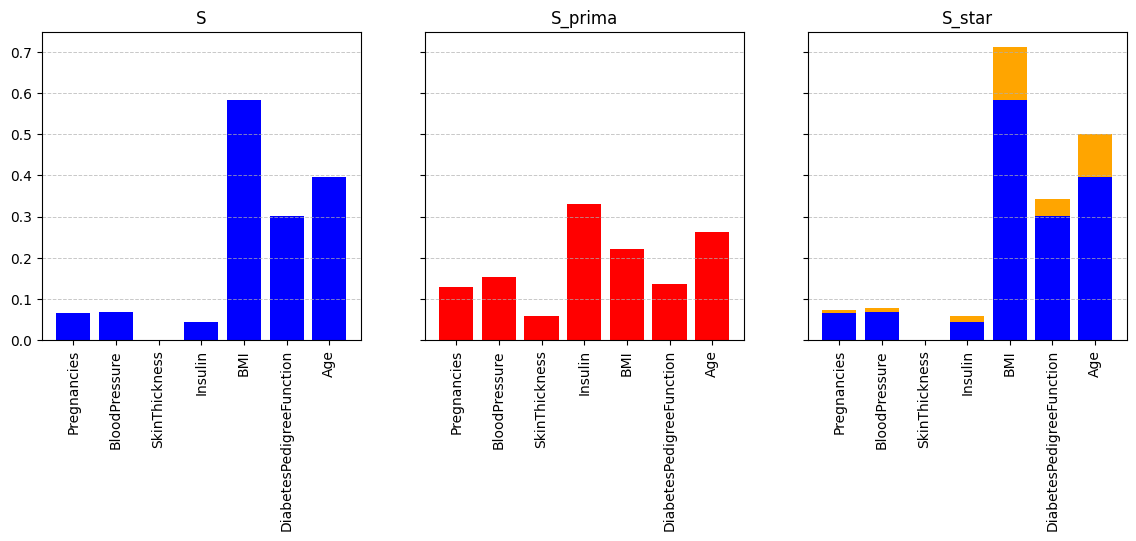

[0.07300808173260899,
 0.07897425177230125,
 0.0,
 0.058529301490460324,
 0.7131131447679857,
 0.3438135644603483,
 0.5003702416514249]

In [168]:
algoritmo_obtencion_valores(X, vars_no_inter=['Glucose'],model=model, sistema_combinacion = 'mult_plus', scaled = True, alpha = 0, 
                            sistema_contribucion = 'feature_tree',num_valores_contribucion = 300, verbose = 3)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

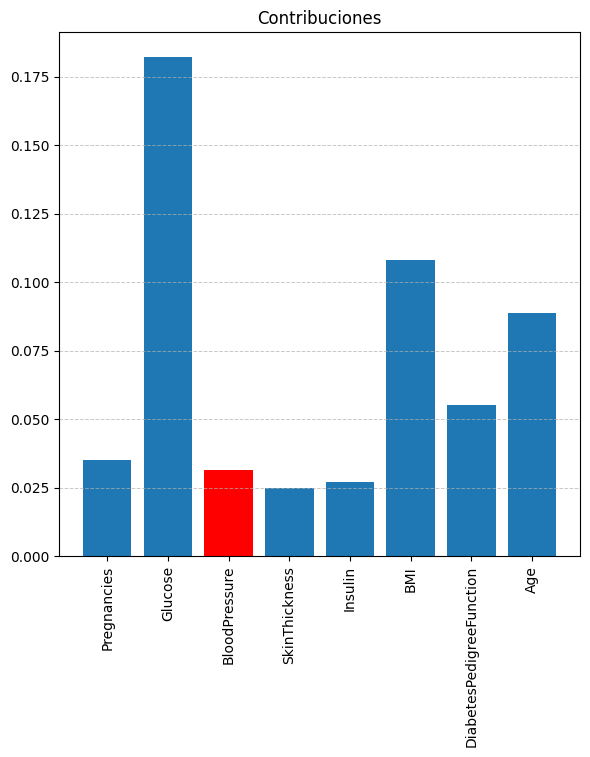

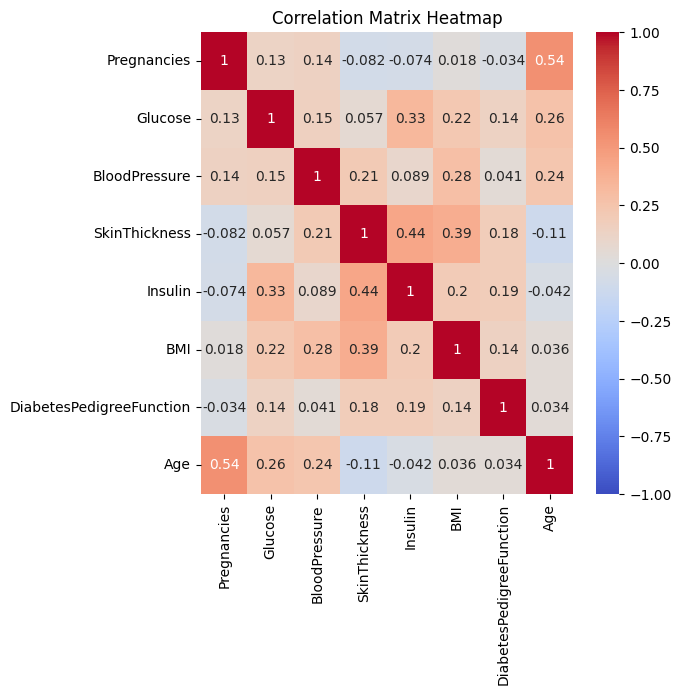

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


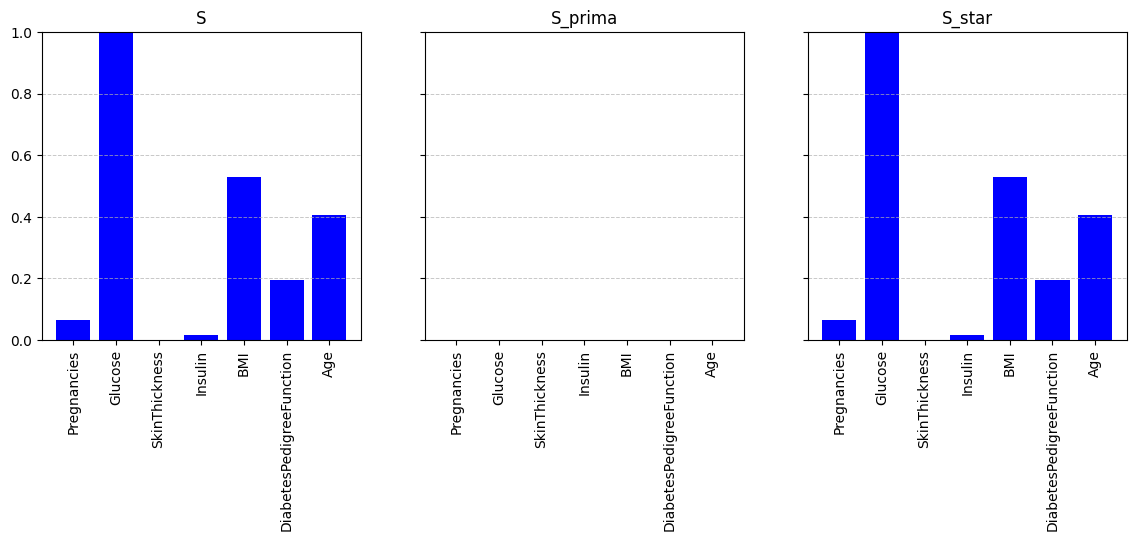

[0.06494930874182245,
 0.9999999999999999,
 0.0,
 0.01511664131095572,
 0.5298427391426633,
 0.19442864963448406,
 0.4061996225376472]

In [146]:
algoritmo_obtencion_valores(X, vars_no_inter=['BloodPressure'],model=model, sistema_combinacion = 'mult_plus', scaled = True, alpha = 0, 
                            sistema_contribucion = 'shap',num_valores_contribucion = 200, verbose = 3)

Dataset de regresión

In [48]:
# Load the dataset # https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
df = pd.read_csv('Housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [49]:
# como este modelo tiene variables categoricas, las pasamos a no categoricas
from sklearn.preprocessing import OneHotEncoder

# Binary encoding for binary categorical variables
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
for col in binary_columns:
    df[col] = df[col].map({'yes': 1, 'no': 0})

# non binarey encoding
encoder = OneHotEncoder()
encoded = encoder.fit_transform(df[['furnishingstatus']]).toarray()

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['furnishingstatus']))
df = pd.concat([df, encoded_df], axis=1).drop('furnishingstatus', axis=1)
df.head()


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1.0,0.0,0.0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1.0,0.0,0.0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,0.0,1.0,0.0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1.0,0.0,0.0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1.0,0.0,0.0


In [50]:
# Split into X,y and train and test
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Entrenamos a nuestro modelo de caja negra

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score


model = GradientBoostingRegressor(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


print("Classification Report:")
print(r2_score(y_test, y_pred))

Classification Report:
0.6664858736473611


In [51]:
non_interpretable_feature_names = ['furnishingstatus_furnished','furnishingstatus_semi-furnished','furnishingstatus_unfurnished']
algoritmo_obtencion_valores(X, vars_no_inter,model, sistema_combinacion = 'mult', scaled = False, alpha = 0, sistema_contribucion = 'shap',num_valores_contribucion = 300)

NameError: name 'vars_no_inter' is not defined

## Ejemplo Vino

In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [120]:
wine = pd.read_csv('./winequality-red.csv', sep=';')
print(wine.shape)
wine.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [114]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Integrate new features to original dataset

# Split data into training and testing sets
# X = lettuce.drop(columns=['Plant_ID', 'Date', 'Growth Days'], axis=1)
# y = lettuce['Growth Days']
X = wine.drop(columns=['quality'], axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize model
model_lr = LinearRegression()


In [115]:
model_lr.fit(X_train, y_train)

y_pred = model_lr.predict(X_test)

print("Metrics Report:")
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

Metrics Report:
0.4031803412796233
0.390025143963954
0.5035304415524378


<Axes: >

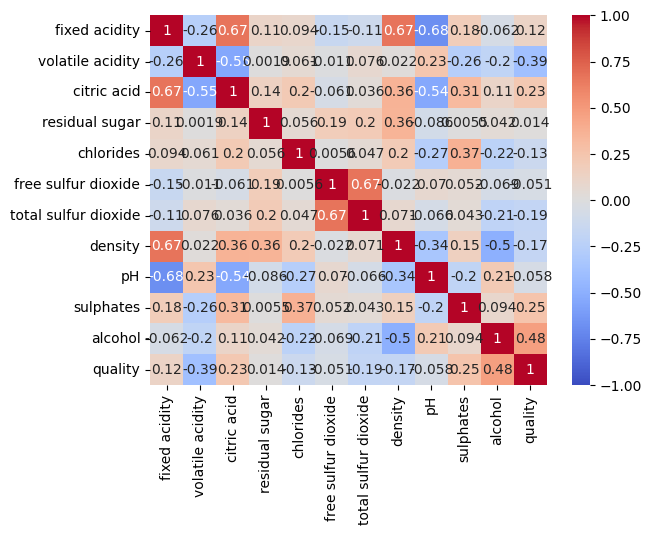

In [116]:
sns.heatmap(wine.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

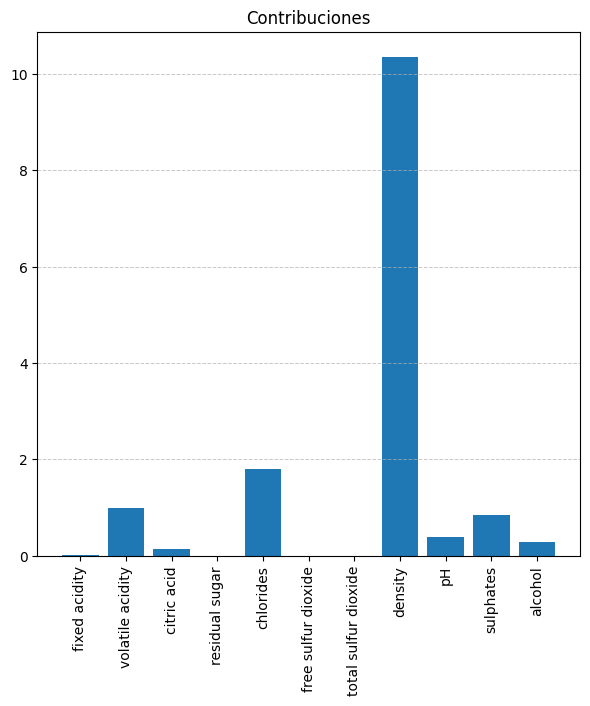

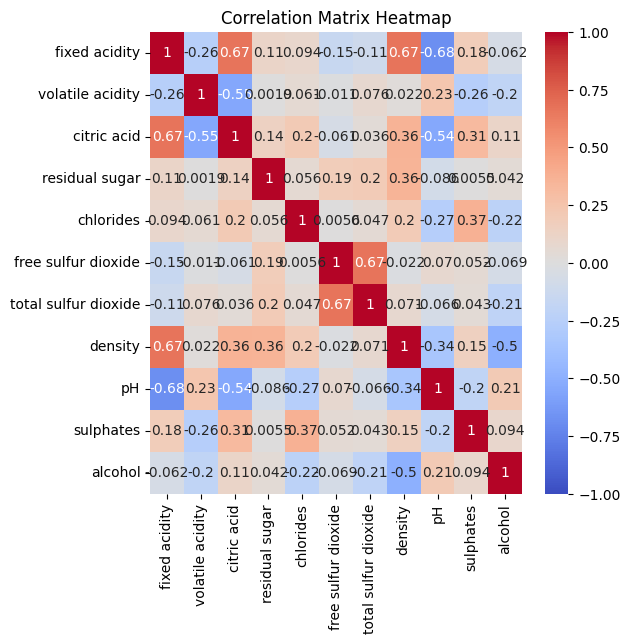

[0.02000213070101666, 0.0003341331475922424, 0.02501063870749133, 0.009687368989168624, 0.032581886479487, 0.03536793551918204, 0.06188857027108824, 0.014919186269817319, 0.0009630212448755032, 0.007331987835380643]


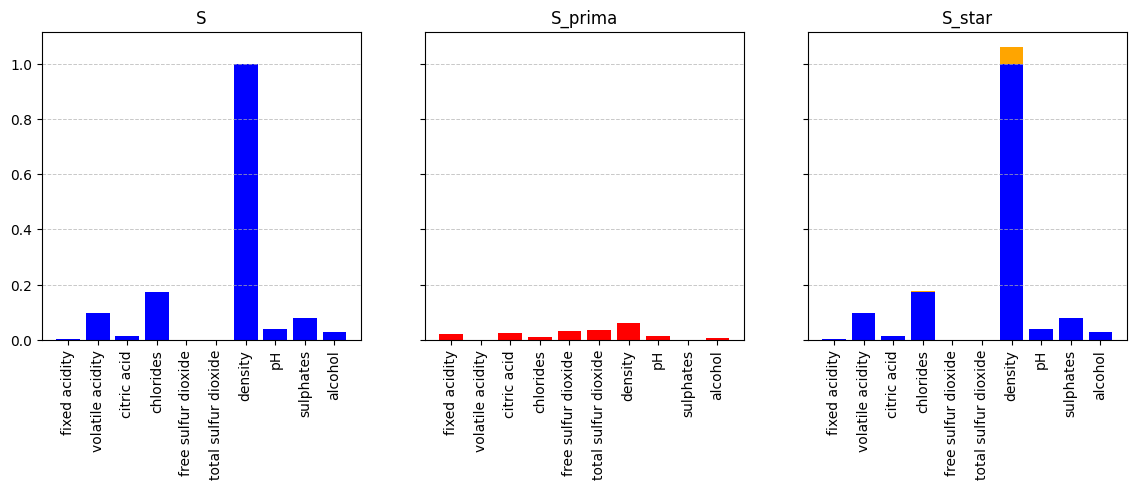

[0.0019162970197810054,
 0.09644358731501994,
 0.013587996527882189,
 0.17591153889214228,
 0.00019786448254355672,
 0.0,
 1.0618885702710883,
 0.03825515630707671,
 0.08101448111149477,
 0.02708606357742855]

In [138]:
algoritmo_obtencion_valores(X, vars_no_inter=['residual sugar'],model=model_lr, sistema_combinacion = 'mult_plus', scaled = True, alpha = 0, 
                            sistema_contribucion = 'feature_lin',num_valores_contribucion = 300, verbose = 3)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/200 [00:00<?, ?it/s]

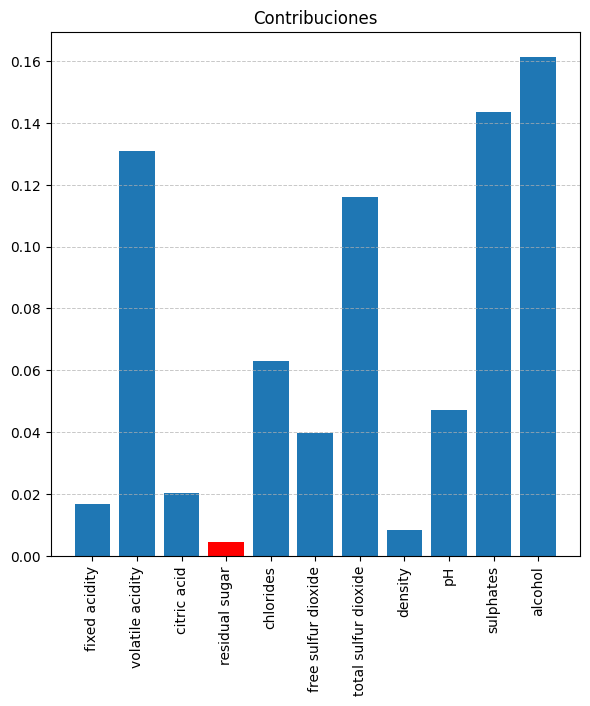

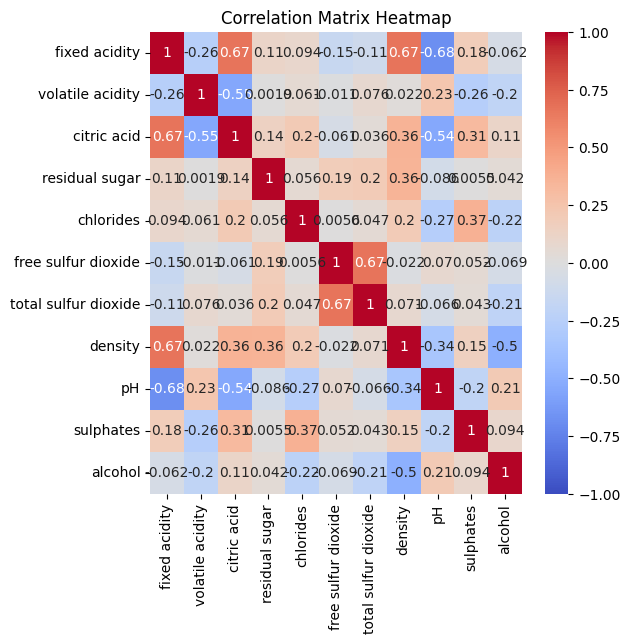

[0.04098407769718888, 0.0006846340065876431, 0.05124643846028083, 0.0198492795226683, 0.06675981608941346, 0.07246839044170665, 0.12680878904712348, 0.03056919777201276, 0.001973216659463938, 0.01502313746529066]


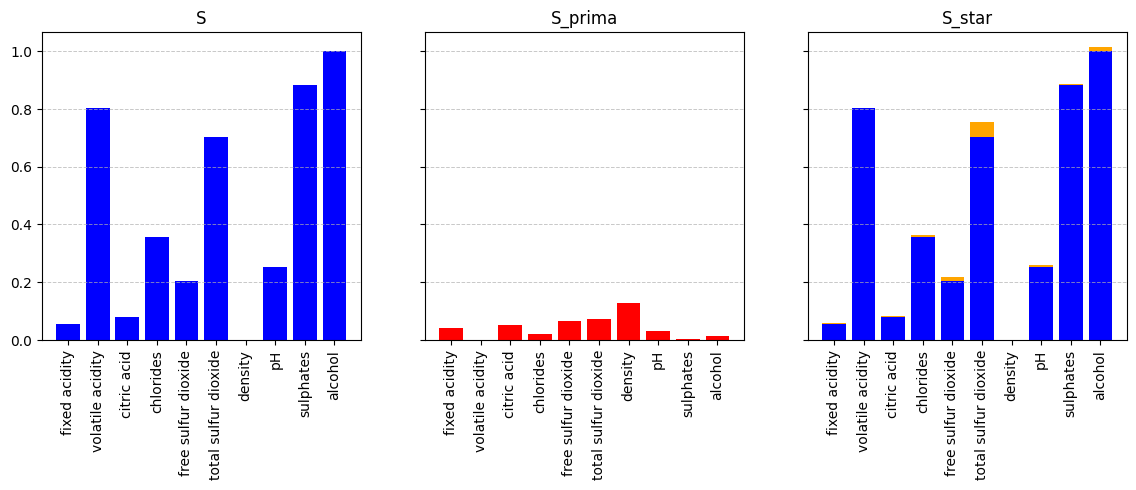

[0.057138557589940554,
 0.8013891598712698,
 0.08210174224894277,
 0.3640678284491418,
 0.2175036839409847,
 0.7543975623451461,
 0.0,
 0.2609129258840695,
 0.8852403447777678,
 1.0150231374652907]

In [139]:
algoritmo_obtencion_valores(X, vars_no_inter=['residual sugar'],model=model_lr, sistema_combinacion = 'mult_plus', scaled = True, alpha = 0, 
                            sistema_contribucion = 'shap',num_valores_contribucion = 200, verbose = 3)

In [43]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

y_pred = model_rf.predict(X_test)

print("Metrics Report:")
print(r2_score(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

Metrics Report:
0.5298239364007233
0.3072628125
0.42603125


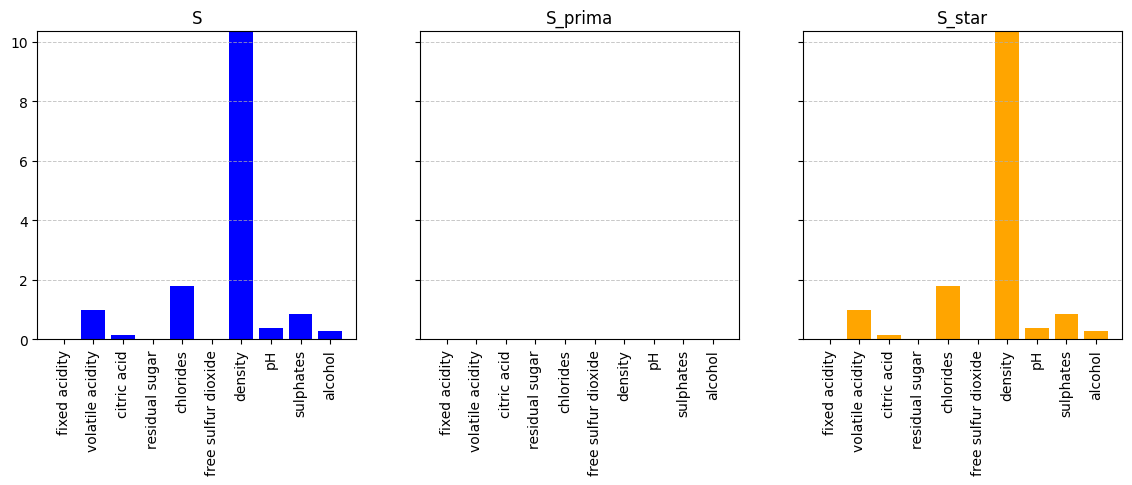

[9.520457538238356e-06,
 0.00027908027375196767,
 1.8230717486475614e-05,
 4.856499252251033e-06,
 0.00031202695503447915,
 1.368904509174309e-05,
 0.0026894407792596273,
 9.536558818622543e-05,
 0.00013163174687711698,
 0.00021131038144545187]

In [69]:
algoritmo_obtencion_valores(X, vars_no_inter=['total sulfur dioxide'],model=model_lr, sistema_combinacion = 'mult', scaled = True, alpha = 0, 
                            sistema_contribucion = 'feature_lin',num_valores_contribucion = 300, verbose = 1)